<a href="https://colab.research.google.com/github/PranjalSahu/OAI_analysis_2/blob/pranjal/notebooks/DaskComputation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages

!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets
!pip install icon-registration==0.3.4
!pip install "dask[complete]"
!pip install coiled dask distributed
!pip install torch
!pip install jupyter
!pip install girder_client
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git
!pip install git+https://github.com/PranjalSahu/OAI_analysis_2.git#egg=oai_package

In [1]:
# All Imports

import numpy as np

import itkConfig
itkConfig.LazyLoading = False

import itk
import vtk
import itkwidgets
import icon_registration
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
from oai_analysis_2 import mesh_processing as mp

import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

from dask import delayed, compute, visualize
from dask.distributed import Client, progress, LocalCluster

urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!


In [4]:
# Create Dask Client. This will also spawn dask worker and scheduler

import coiled

use_coiled = True

if use_coiled:
  # # Create the environment
  # coiled.create_software_environment(
  #   name="oai1",
  #   pip="coiled_requirements.txt",
  # )

  name = None
  cluster = coiled.Cluster(n_workers=4,
                         worker_cpu=2,
                         worker_memory='6G',
                         name=name,
                         software='pranjal-sahu/oai1')
  client = Client(cluster)
  client
else:
  cluster = LocalCluster(processes=False)
  client = Client(cluster)
  client

Output()

Found software environment build
Created fw rule: inbound [8786-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-pranjal09-143970-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-143970-firewall -> coiled-dask-pranjal09-143970-firewall]
Created FW rules: coiled-dask-pranjal09-143970-cluster-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-143970-cluster-firewall -> coiled-dask-pranjal09-143970-cluster-firewall]
Created scheduler VM: coiled-dask-pranjal09-143970-scheduler (type: t3a.medium, ip: ['44.204.186.155'])


Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 5.1.1  | 6.1       | 6.1     |
+---------+--------+-----------+---------+


In [9]:
client

<Client: 'tls://10.4.14.33:8786' processes=4 threads=8, memory=19.31 GiB>

In [5]:
# Download the relevant files such as input image, atlas image, segmented TC and FC maps

!girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Local metadata does not exists. Falling back to download.
[####################################]  74.74M/74.74M  100%  atlas_image.nii.gz          
[####################################]  76.70M/76.70M  100%  FC_probmap.nii.gz          
[####################################]  27.96M/27.96M  100%  image_preprocessed.nii.gz          
[####################################]  76.66M/76.66M  100%  TC_probmap.nii.gz          


In [6]:
# All Function Definitions with Dask Delayed Decorator to perform parallel Computing

@delayed(nout=2)
def read_images(image_preprocessed, atlas_image):
    image_A = itk.imread(image_preprocessed, itk.D)
    image_B = itk.imread(atlas_image, itk.D)
    return image_A, image_B

def register_images(image_A, image_B):
    model = pretrained_models.OAI_knees_gradICON_model()
    model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    return phi_AB

@delayed
def deform_probmap_FC(phi_AB, image_A, image_B):
    fc_prob_file = './OAIData/FC_probmap.nii.gz'

    FC_prob = itk.imread(fc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image_FC = itk.resample_image_filter(FC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    return warped_image_FC

@delayed
def deform_probmap_TC(phi_AB, image_A, image_B):
    tc_prob_file = './OAIData/TC_probmap.nii.gz'

    TC_prob = itk.imread(tc_prob_file)

    interpolator = itk.LinearInterpolateImageFunction.New(image_B)
    warped_image_TC = itk.resample_image_filter(TC_prob, 
        transform=phi_AB, 
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin()
    )

    return warped_image_TC

# Convert from VTK Mesh to ITK Mesh to make it serializable
def get_itk_mesh(vtk_mesh):
    Dimension = 3
    PixelType = itk.D
    
    MeshType = itk.Mesh[PixelType, Dimension]
    itk_mesh = MeshType.New()
    
    # Get points array from VTK mesh
    points = vtk_mesh.GetPoints().GetData()
    points_numpy = np.array(points).flatten().astype('float32')
        
    polys = vtk_mesh.GetPolys().GetData()
    polys_numpy = np.array(polys).flatten()

    # Triangle Mesh
    vtk_cells_count = vtk_mesh.GetNumberOfPolys()
    polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension+1])

    # Extracting only the points by removing first column that denotes the VTK cell type
    polys_numpy = polys_numpy[:, 1:]
    polys_numpy = polys_numpy.flatten().astype(np.uint64)

    # Get point data from VTK mesh to insert in ITK Mesh
    point_data_numpy = np.array(vtk_mesh.GetPointData().GetScalars())#.astype('float64')
    
    # Get cell data from VTK mesh to insert in ITK Mesh
    cell_data_numpy = np.array(vtk_mesh.GetCellData().GetScalars())#.astype('float64')
    
    itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
    itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy), itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
    itk_mesh.SetPointData(itk.vector_container_from_array(point_data_numpy))
    itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))    
    return itk_mesh
    
@delayed
def get_thickness_FC(warped_image_FC):
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_FC = get_itk_mesh(distance_inner_FC)
    return distance_inner_FC

@delayed
def get_thickness_TC(warped_image_TC):
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    distance_inner_TC = get_itk_mesh(distance_inner_TC)
    return distance_inner_TC

@delayed(nout=2)
def get_paths():
    image_preprocessed = "./OAIData/image_preprocessed.nii.gz"
    atlas_image = "./OAIData/atlas_image.nii.gz"

    return image_preprocessed, atlas_image

@delayed
def only_register_images(image_A, image_B):
    phi_AB  = register_images(image_A=image_A, image_B=image_B)
    return phi_AB

In [7]:
# Create Dask Computation Graph

result = []

image_preprocessed, atlas_image   = get_paths()

image_A, image_B  = read_images(image_preprocessed, atlas_image)
phi_AB            = only_register_images(image_A, image_B)

warped_image_FC = deform_probmap_FC(phi_AB, image_A, image_B)
warped_image_TC = deform_probmap_TC(phi_AB, image_A, image_B)

thickness_FC = get_thickness_FC(warped_image_FC)
thickness_TC = get_thickness_TC(warped_image_TC)

result.append(thickness_FC)
result.append(thickness_TC)

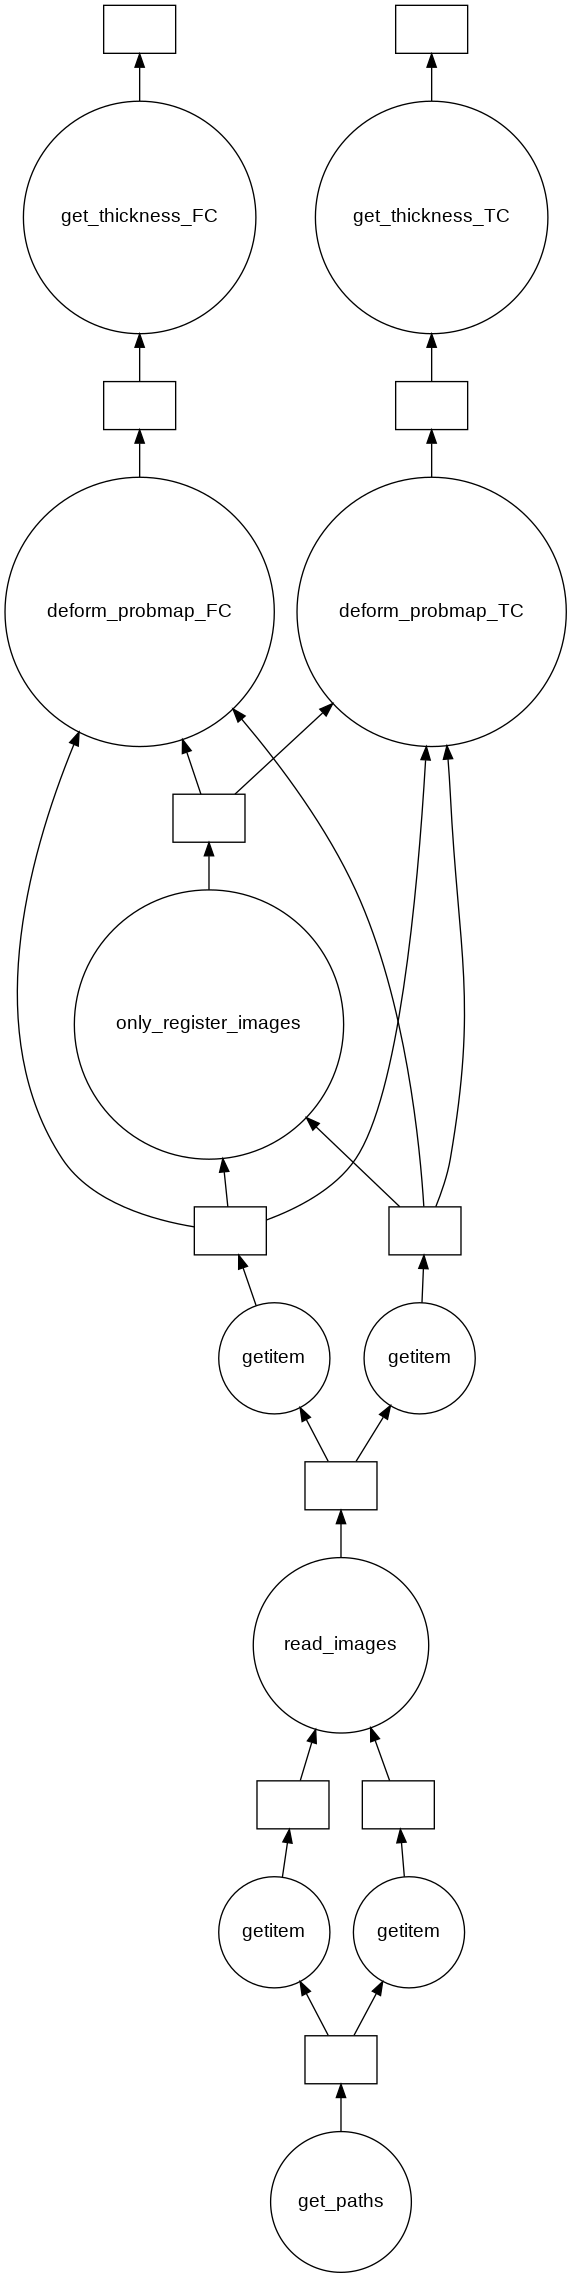

In [8]:
# Visualize Dask Computation Graph

visualize(*result)

In [ ]:
# Perform computation
%%time

l = compute(*result)

![DaskProgress](https://user-images.githubusercontent.com/1044135/163692457-40a41395-3d83-4928-9445-528cd025a7b9.png)


In [ ]:
# Write the result meshes

distance_inner_FC = l[0]
distance_inner_TC = l[1]

itk.meshwrite(distance_inner_FC, 'itk_distance_inner_FC.vtk')
itk.meshwrite(distance_inner_TC, 'itk_distance_inner_TC.vtk')

In [ ]:
# Visualize the meshes with thickness as cell data

# To enable running the itkwidgets window on colab
from google.colab import output
output.enable_custom_widget_manager()

a1 = vtk.vtkPolyDataReader()
a1.SetFileName('itk_distance_inner_FC.vtk')
a1.Update()
distance_inner_FC = a1.GetOutput()

itkwidgets.view(geometries=[distance_inner_FC])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…